# Bad Antennas for H1C IDR3.1

Comissioning has given us a list of bad antenna-days. I want to harmonize these in a way that excludes antennas that have a good chance of being bad because they were marked as bad on neighboring days. 

For IDR2.1, any antenna that was marked as bad for more than one day was flagged for all days. That worked OK with 18 days, but is more problematic for 107 days. Instead, I've done the following: 

* I've broken the days into 4 epochs, separated by significant gaps the days. There are two days (2458172, and 2458173) that are between epochs, so I assign them to both.
* If more than 10% of the days in an epoch are flagged for a given antenna, the antenna is flagged for the entire epoch. 
* If more than 60% of the days are flagged after the per-epoch cut (i.e. if 3/4 of the epochs are flagged), the antenna is flagged for all epochs (i.e. the entire season).
* I also removed antennas 155, 156, 180, 181, 182, 183, 334, 338 because they aren't on the main redundantly calibratable grid. And I've removed 54 because it has a consistently high chi^2 per antenna in redcal.

This expands the total number of flagged antenna-days from about 11% to about 20% of the total available (not including the off-grid antennas). Ideally, this conservative cut will help safeguard us for bad antennas in our calibration while not sacrificing too much sensitivity.

In [1]:
from __future__ import print_function, division, absolute_import

import csv
from collections import OrderedDict as odict
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
off_grid = [155, 156, 180, 181, 182, 183, 334, 338]
# Not redundantly calibratable as stands

not_red = [0, 11, 24, 50, 53, 54, 67, 69, 98, 122, 136] 
# In my experiments with redcal, these antenna are often 4 sigma outliers in chi^2 per antenna 
# this is largely based on evidence with IDR2.2 and should be revisited for IDR3
# see https://files.slack.com/files-pri/T0KMWB8P3-FK7LHD8LD/image.png
# and https://files.slack.com/files-pri/T0KMWB8P3-FKERMDFLY/image.png
# and https://files.slack.com/files-pri/T0KMWB8P3-FK4FKKH6E/image.png

group1 = [2458041, 2458042, 2458043, 2458044, 2458045, 2458046, 2458047, 2458048, 2458049, 2458050, 2458051, 2458052, 2458054, 2458055, 2458056, 2458058, 2458059, 2458061, 2458062, 2458063, 2458064, 2458065, 2458066, 2458067, 2458068, 2458069, 2458070, 2458071, 2458072]
group2 = [2458081, 2458083, 2458084, 2458085, 2458086, 2458087, 2458088, 2458089, 2458090, 2458091, 2458092, 2458094, 2458095, 2458096, 2458097, 2458098, 2458099, 2458101, 2458102, 2458103, 2458104, 2458105, 2458106, 2458107, 2458108, 2458109, 2458110, 2458111, 2458112, 2458113, 2458114, 2458115, 2458116]
group3 = [2458134, 2458135, 2458136, 2458139, 2458140, 2458141, 2458142, 2458143, 2458144, 2458145, 2458146, 2458147, 2458148, 2458149, 2458150, 2458151, 2458153, 2458154, 2458155, 2458157, 2458158, 2458159, 2458161, 2458172, 2458173]
group4 = [2458172, 2458173, 2458185, 2458187, 2458188, 2458189, 2458190, 2458192, 2458195, 2458196, 2458197, 2458198, 2458199, 2458200, 2458201, 2458202, 2458203, 2458204, 2458205, 2458206, 2458207, 2458208]

In [3]:
# Obtained from here: https://docs.google.com/spreadsheets/d/1eDjan-p9ffmfkqrXw9V1HYDqd-FIep3KUgLNz1MU6-o/edit#gid=1450598387
with open('HERA_observing_log - IDR3.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    bad_ants, Nants, all_ants = odict(), odict(), odict()
    for row in reader:
        if row['IDR3 good'] == 'TRUE': 
            bad_ants[int(row['Julian'])] = [int(ant) for ant in row['Bad Antennas'].split(',')]
            all_ants[int(row['Julian'])] = [int(ant) for ant in row['All Antennas'].split(',')]
            Nants[int(row['Julian'])] = int(row['Nants'])
all_bad_ants = sorted(set([ant for ants in bad_ants.values() for ant in ants] + off_grid))
days = np.array(list(bad_ants.keys()))
good_days = len(bad_ants)
bad_days_by_ant = {ant: np.array([ant in bad_ants[day] or (ant in off_grid and ant in all_ants[day]) for day in days]) for ant in all_bad_ants}

In [4]:
day_groups = [group1, group2, group3, group4]
day_slices = [np.array([day in group for day in days]) for group in day_groups]

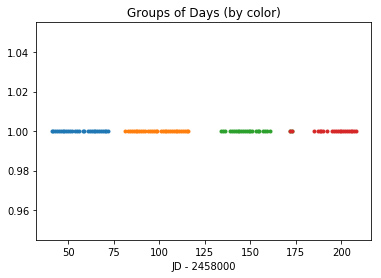

In [5]:
plt.figure()
for group in day_groups:
    plt.plot(np.array(group) - 2458000, np.ones_like(group),'.')
plt.title('Groups of Days (by color)')
plt.xlabel('JD - 2458000');

In [6]:
final_flags = deepcopy(bad_days_by_ant)
for ant in final_flags:
    for ds in day_slices:
        if np.sum(final_flags[ant][ds])*1.0/len(final_flags[ant][ds]) > .1:
            final_flags[ant][ds] = True
        if np.sum(final_flags[ant])*1.0/good_days > .6:
            final_flags[ant][:] = True

In [7]:
for ant in not_red:
    final_flags[ant] = np.ones(len(days), dtype=bool) 

Total Antenna-Days: 5961
Total Antenna-Days After Commissioning Cuts: 5278
Total Antenna-Days After Analysis Cuts: 4103
Total Redundant Antenna Days: 4818
Total Redundant Antenna Days After Comissioning Cuts: 4417
Total Redundant Antenna Days After Analysis Cuts: 4103


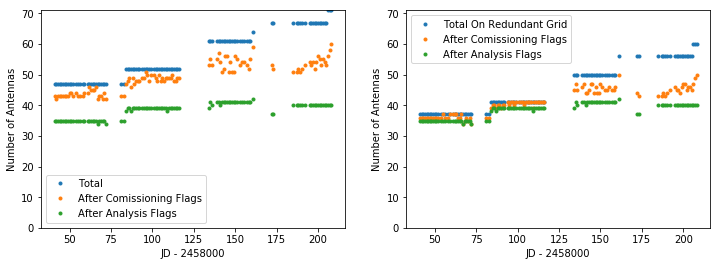

In [8]:
ant_days = Nants.values()
ant_days_comm = [len([ant for ant in all_ants[day] if ant not in bad_ants[day]]) for day in days]
ant_days_analysis = [len([ant for ant in all_ants[day] if ((ant not in final_flags) or not final_flags[ant][n])]) for n,day in enumerate(days)]
red_ant_days = [len([ant for ant in all_ants[day] if ant not in not_red]) for day in days]
red_ant_days_comm = [len([ant for ant in all_ants[day] if ant not in not_red and ant not in bad_ants[day]]) for day in days]
red_ant_days_analysis = [len([ant for ant in all_ants[day] if (ant not in not_red) and ((ant not in final_flags) or not final_flags[ant][n])]) for n,day in enumerate(days)]

print('Total Antenna-Days:', np.sum(list(ant_days)))
print('Total Antenna-Days After Commissioning Cuts:', np.sum(ant_days_comm))
print('Total Antenna-Days After Analysis Cuts:', np.sum(ant_days_analysis))
print('Total Redundant Antenna Days:', np.sum(red_ant_days))
print('Total Redundant Antenna Days After Comissioning Cuts:', np.sum(red_ant_days_comm))
print('Total Redundant Antenna Days After Analysis Cuts:', np.sum(red_ant_days_analysis))

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(days - 2458000, ant_days,'.', label='Total')
plt.plot(days - 2458000, ant_days_comm,'.', label='After Comissioning Flags')
plt.plot(days - 2458000, ant_days_analysis,'.', label='After Analysis Flags')
plt.xlabel('JD - 2458000')
plt.ylim([0, np.max(list(ant_days))])
plt.ylabel('Number of Antennas')
plt.legend()

plt.subplot(122)
plt.plot(days - 2458000, red_ant_days,'.', label='Total On Redundant Grid')
plt.plot(days - 2458000, red_ant_days_comm,'.', label='After Comissioning Flags')
plt.plot(days - 2458000, red_ant_days_analysis,'.', label='After Analysis Flags')
plt.xlabel('JD - 2458000')
plt.ylim([0,np.max(list(ant_days))])
plt.ylabel('Number of Antennas')
plt.legend();

In [9]:
for day in days:
    with open('bad_ants/' + str(day) + '.txt', 'w') as f:
        for ant in sorted(final_flags.keys()):
            if (ant in not_red and ant in all_ants[day]) or (day in np.array(days)[final_flags[ant]]):
                f.write(str(ant) + '\n')

In [10]:
print('Fraction of antenna-days flagged by commissioning:', 
      np.sum(list(bad_days_by_ant.values())) * 1.0 / np.sum(list(Nants.values())))
print('Fraction of antenna-days flagged for analysis:', 
      np.sum(list(final_flags.values())) * 1.0 / np.sum(list(Nants.values())))

Fraction of antenna-days flagged by commissioning: 0.1155846334507633
Fraction of antenna-days flagged for analysis: 0.34524408656265726


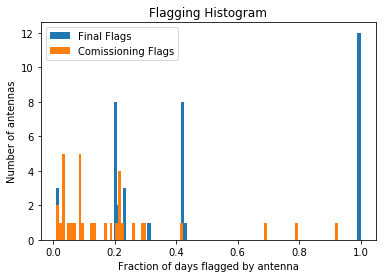

In [11]:
plt.figure()
plt.hist([np.sum(day_flags)/1.0/good_days for day_flags in final_flags.values()], bins=100, label='Final Flags')
plt.hist([np.sum(day_flags)/1.0/good_days for day_flags in bad_days_by_ant.values()], bins=100, label='Comissioning Flags')
plt.legend()
plt.title('Flagging Histogram')
plt.xlabel('Fraction of days flagged by antenna')
plt.ylabel('Number of antennas');

## Per Antenna Flagging

/Users/jsdillon/anaconda2/envs/python3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


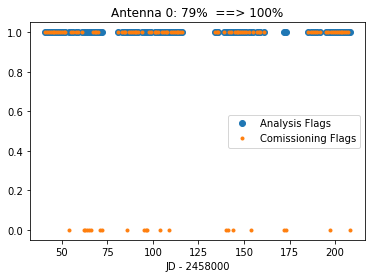

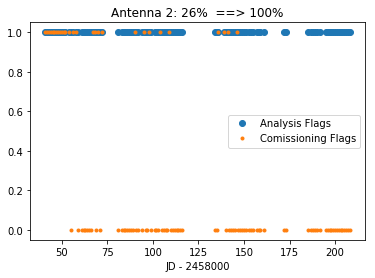

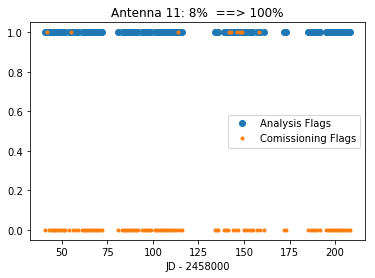

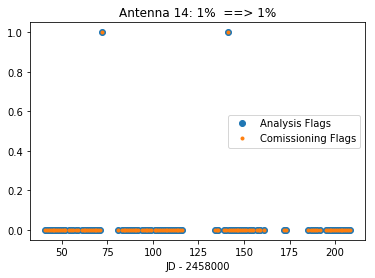

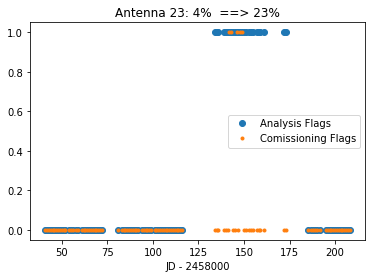

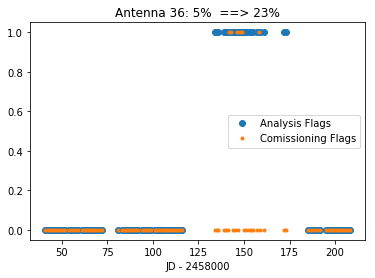

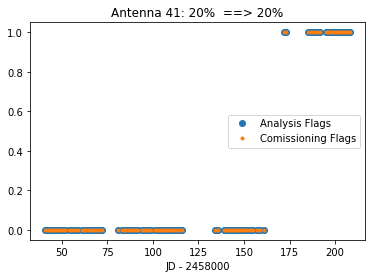

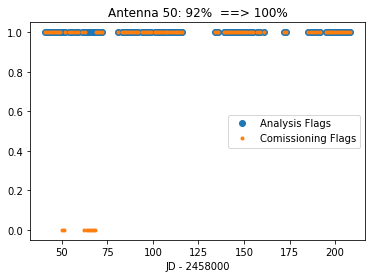

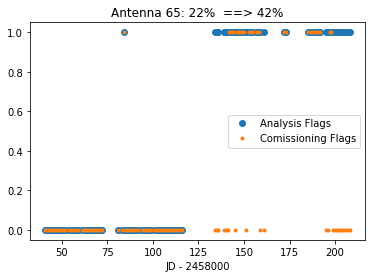

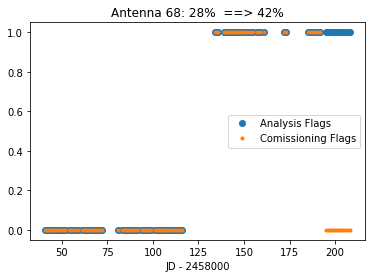

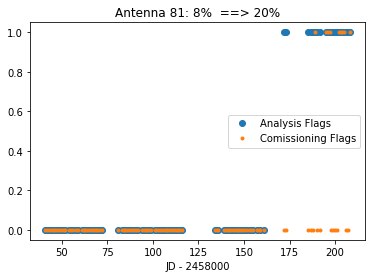

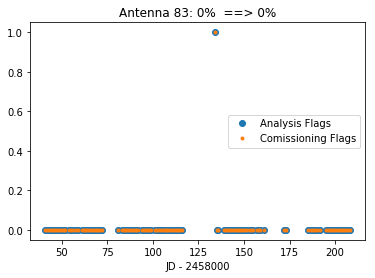

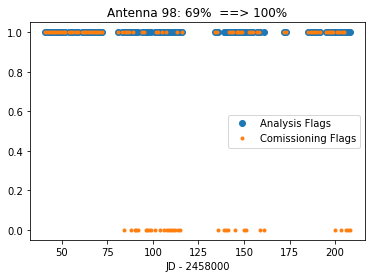

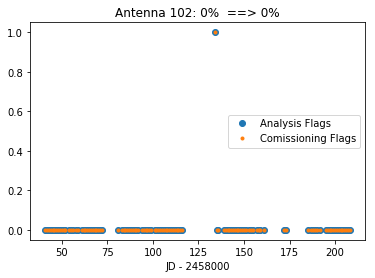

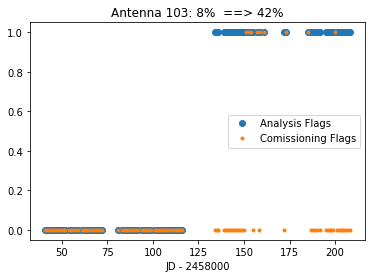

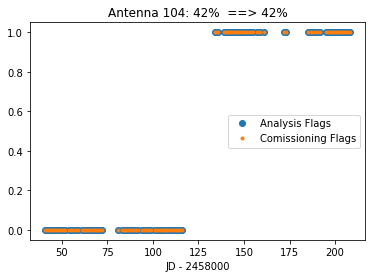

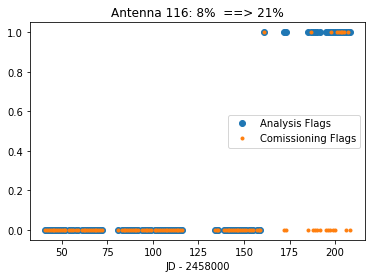

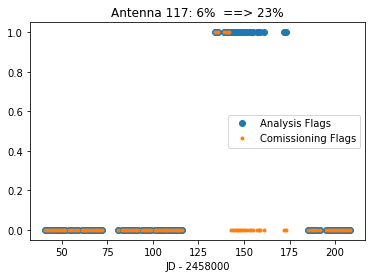

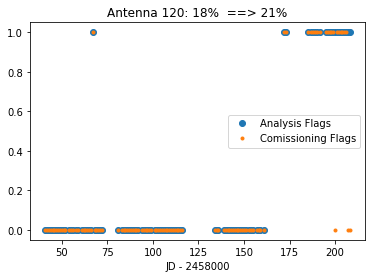

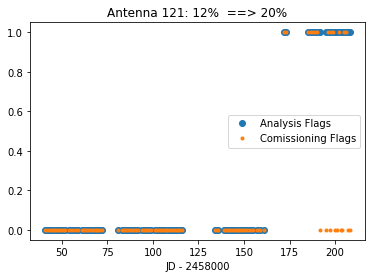

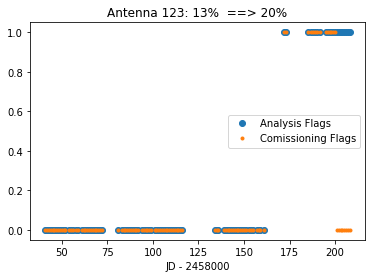

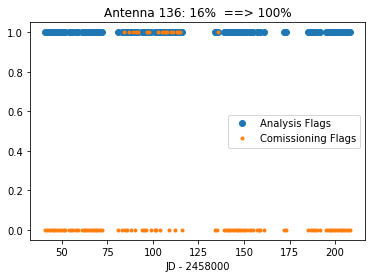

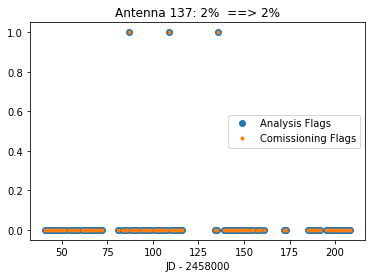

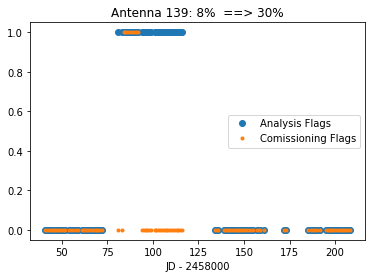

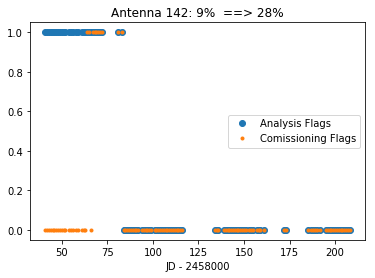

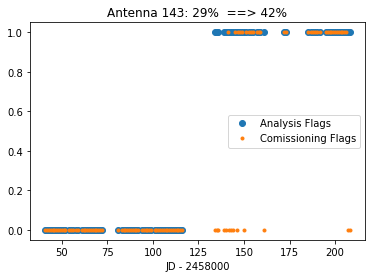

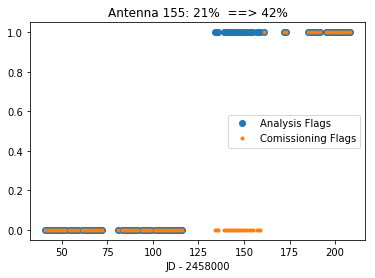

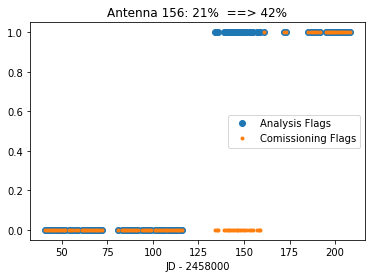

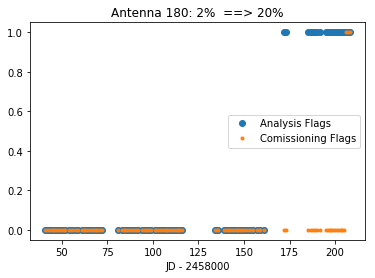

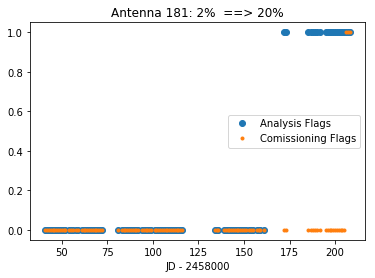

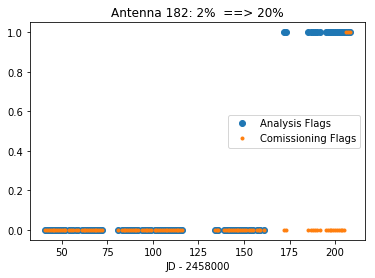

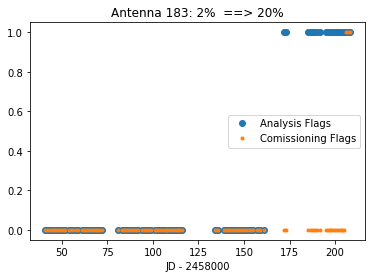

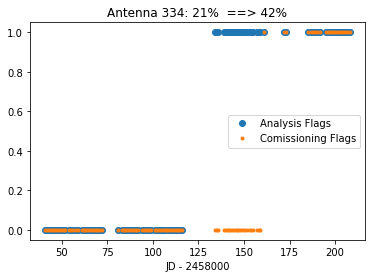

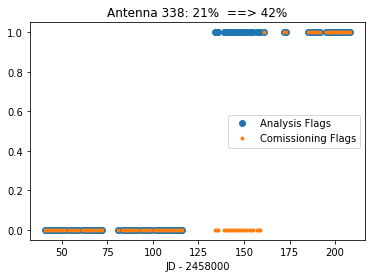

In [12]:
for ant in sorted(list(bad_days_by_ant.keys())):
    plt.figure()
    plt.plot(np.array(list(bad_ants.keys()))-2458000, final_flags[ant], 'o', label='Analysis Flags')
    plt.plot(np.array(list(bad_ants.keys()))-2458000, bad_days_by_ant[ant], '.', label='Comissioning Flags')
    plt.legend(loc=7)
    plt.title('Antenna ' + str(ant) + ': ' + str(int(np.sum(bad_days_by_ant[ant]) *100.0 / good_days)) + 
              '%  ==> ' + str(int(np.sum(final_flags[ant]) *100.0 / good_days)) + '%')
    plt.xlabel('JD - 2458000')